# Standard LVGP regression models

In this notebook, we will demonstrate training and analyzing standard LVGP models on the borehole dataset

In [1]:
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import gpytorch

from lvgp_pytorch.models import LVGPR
from lvgp_pytorch.optim import fit_model_scipy
from lvgp_pytorch.optim.mll_noise_tune import noise_tune
from lvgp_pytorch.utils.variables import NumericalVariable,CategoricalVariable,IntegerVariable
from lvgp_pytorch.utils.input_space import InputSpace

from typing import Dict
from copy import deepcopy

%matplotlib inline
plt.rcParams['figure.dpi']=150
plt.rcParams['font.family']='serif'

In [2]:
# configuration space
config = InputSpace()
r = NumericalVariable(name='r',lower=100,upper=50000)
Tu = NumericalVariable(name='T_u',lower=63070,upper=115600)
Hu = NumericalVariable(name='H_u',lower=990,upper=1110)
Tl = NumericalVariable(name='T_l',lower=63.1,upper=116)
L = NumericalVariable(name='L',lower=1120,upper=1680)
K_w = NumericalVariable(name='K_w',lower=9855,upper=12045)

r_w = CategoricalVariable(name='r_w',levels=np.linspace(0.05,0.15,5))
H_l = CategoricalVariable(name='H_l',levels=np.linspace(700,820,5))
config.add_inputs([r,Tu,Hu,Tl,L,K_w,r_w,H_l])

config

Input space with variables:

r, Type: Numerical, Range: [100.0,50000.0]
T_u, Type: Numerical, Range: [63070.0,115600.0]
H_u, Type: Numerical, Range: [990.0,1110.0]
T_l, Type: Numerical, Range: [63.1,116.0]
L, Type: Numerical, Range: [1120.0,1680.0]
K_w, Type: Numerical, Range: [9855.0,12045.0]
r_w, Type: Categorical, Levels: {0.05, 0.075, 0.1, 0.125, 0.15}
H_l, Type: Categorical, Levels: {700.0, 730.0, 760.0, 790.0, 820.0}

In [3]:
def borehole(params:Dict)->float:
    numerator = 2*math.pi*params['T_u']*(params['H_u']-params['H_l'])
    den_term1 = math.log(params['r']/params['r_w'])
    den_term2 = 1+ 2*params['L']*params['T_u']/(den_term1*params['r_w']**2*params['K_w']) + \
        params['T_u']/params['T_l']
    
    return numerator/den_term1/den_term2

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

In [4]:
# generate 100 samples
set_seed(1)
num_samples = 100
train_x = torch.from_numpy(
    config.random_sample(np.random,num_samples)
)
train_y = [None]*num_samples

for i,x in enumerate(train_x):
    train_y[i] = borehole(config.get_dict_from_array(x.numpy()))

train_y = torch.tensor(train_y).double()


# generate 1000 test samples
num_samples = 1000
test_x = torch.from_numpy(config.random_sample(np.random,num_samples))
test_y = [None]*num_samples

for i,x in enumerate(test_x):
    test_y[i] = borehole(config.get_dict_from_array(x.numpy()))
    
# create tensor objects
test_y = torch.tensor(test_y).to(train_y)

## Creating a LVGP instance

In [5]:
# create LVGP instance
set_seed(4)
model = LVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
    quant_correlation_class="RBFKernel",
    noise=1, 
    fix_noise=False,
).double()

## Optimization using multiple random starts

In [6]:
# fit model with 50 different starts
reslist,nll_inc = fit_model_scipy(
    model,
    num_restarts=49, # number of starting points
    options={'ftol':1e-6} # options to L-BFGS
)

# set model to eval model; default is in train model
_ = model.eval()

In [7]:
# prediction on test set
with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_mean,test_std = model.predict(test_x,return_std=True)
    
# print RRMSE
rrmse = torch.mean((test_y-test_mean)**2).sqrt()/test_y.std()
print('RRMSE : %5.3f'%rrmse.item())

RRMSE : 0.060


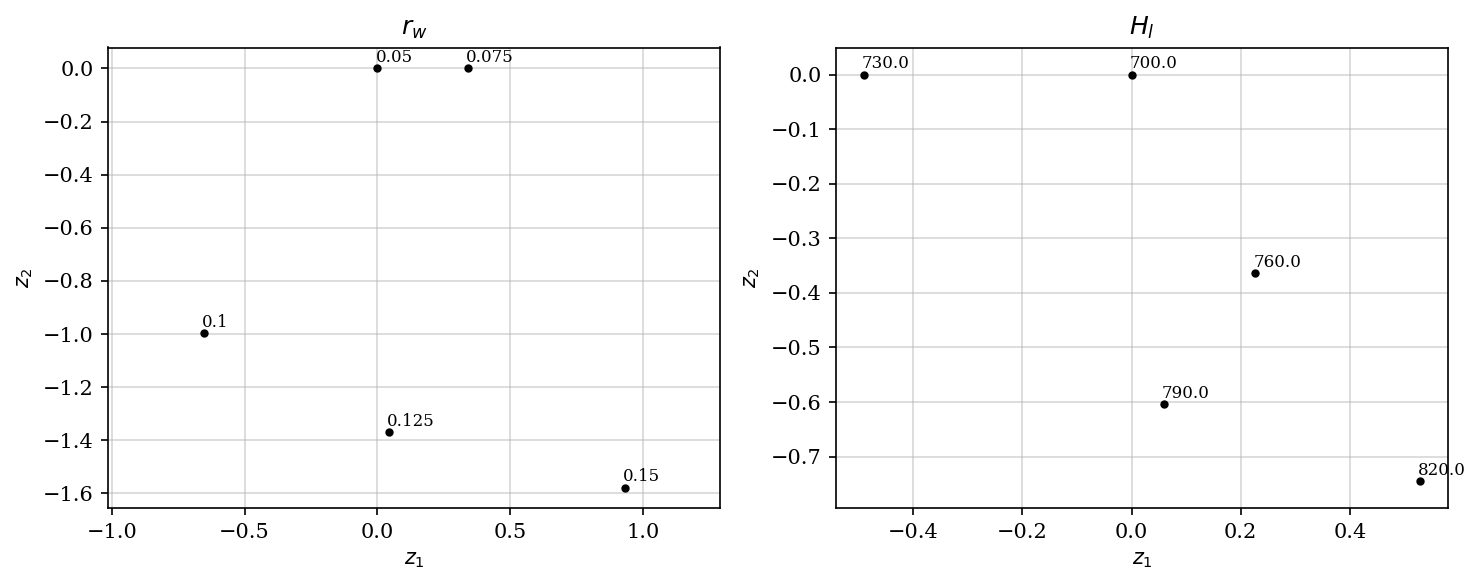

In [8]:
# plot latent values
fig,axs = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    latents = model.lv_mapping_layers[i].latents.detach().numpy()
    _ = axs[i].plot(latents[:,0],latents[:,1],'k.')
    
    hyp = config.get_variable_by_idx(config.qual_index[i])
    # annotate the labels
    for j,level in enumerate(hyp.levels):
        _ = axs[i].annotate(
            str(level),latents[j,:],
            textcoords = 'offset points',
            xytext = (-1,3),
            size='8'
        )
        
    
    _ = axs[i].set_xlabel(r'$z_1$')
    _ = axs[i].set_ylabel(r'$z_2$')
    _ = axs[i].set_title(r'$%s$' %hyp.name)
    _ = axs[i].grid(alpha=0.5)
    _ = axs[i].set_aspect('equal', 'datalim')

fig.tight_layout()

## An improved optimization method

In [9]:
set_seed(4)
model2 = LVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
    quant_correlation_class="RBFKernel",
    noise=1, 
    fix_noise=False
).double()

# optimize noise successively
nll_inc_tuned,opt_history = noise_tune(
    model2,
    num_restarts=19, # num of starting points at the largest noise variance
    options={'ftol':1e-8}
)

# 
print('NLL obtained from multi-start optimization....: %6.2f'%nll_inc)
print('NLL obtained from noise tuning strategy.......: %6.2f'%nll_inc_tuned)

NLL obtained from multi-start optimization....:  -0.11
NLL obtained from noise tuning strategy.......:  -1.23


In [10]:
# prediction on test set
with torch.no_grad():
    # set return_std = False if standard deviation is not needed
    # set include_noise = True, if noise variance is to be included
    # in the posterior variance 
    test_mean2,test_std2 = model2.predict(test_x,return_std=True)
    

# print RRMSE
rrmse = torch.mean((test_y-test_mean2)**2).sqrt()/test_y.std()
print('RRMSE : %5.3f'%rrmse.item())

RRMSE : 0.011


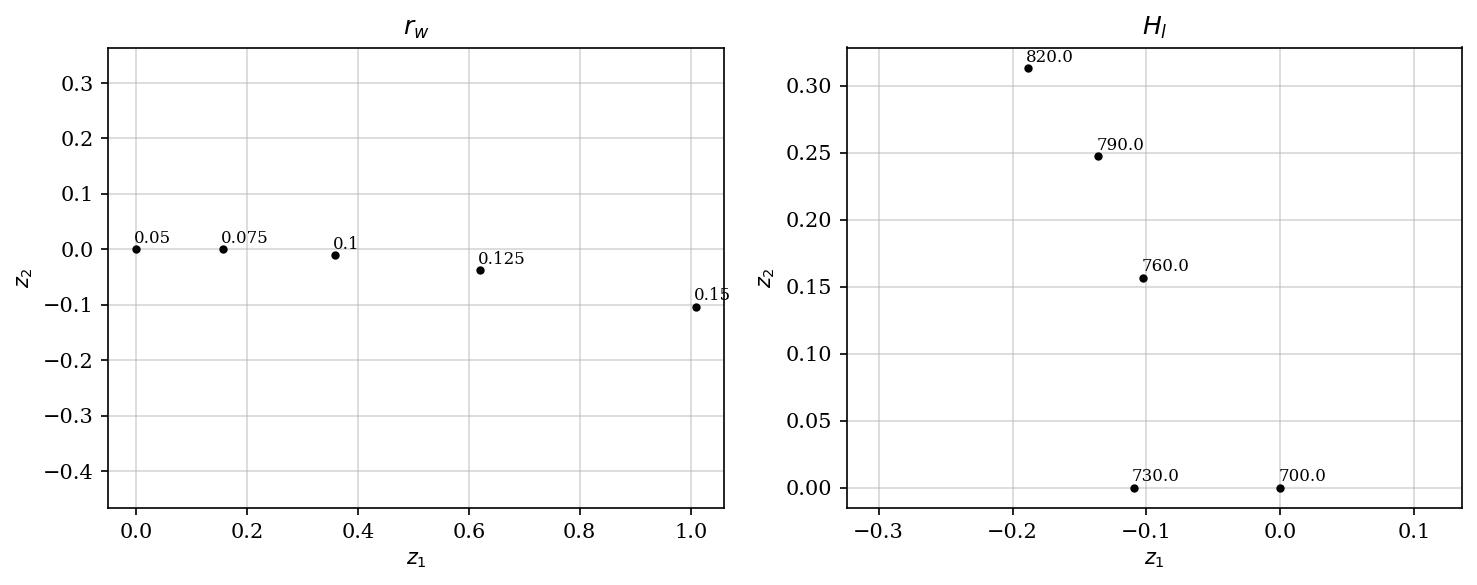

In [11]:
# plot latent values
fig,axs = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    latents = model2.lv_mapping_layers[i].latents.detach().numpy()
    _ = axs[i].plot(latents[:,0],latents[:,1],'k.')
    
    hyp = config.get_variable_by_idx(config.qual_index[i])
    # annotate the labels
    for j,level in enumerate(hyp.levels):
        _ = axs[i].annotate(
            str(level),latents[j,:],
            textcoords = 'offset points',
            xytext = (-1,3),
            size='8'
        )
        
    
    _ = axs[i].set_xlabel(r'$z_1$')
    _ = axs[i].set_ylabel(r'$z_2$')
    _ = axs[i].set_title(r'$%s$' %hyp.name)
    _ = axs[i].grid(alpha=0.5)
    _ = axs[i].set_aspect('equal', 'datalim')

fig.tight_layout()